In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy

from sklearn.model_selection import TimeSeriesSplit

from statistics import mean

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Loading the data

In [2]:
def load_pickle(file):
    objects = []
    with open(file, "rb") as openfile:
        u = pickle._Unpickler(openfile)
        u.encoding = 'latin1'
        df = u.load()
    return df

In [3]:
wthr_df = load_pickle("griddata_gfs_us_20180101_20190826_03_final.p")

In [4]:
wthr_df.head(20)

,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_%,r_pl950_%,shtfl_sfc_wm2,...,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
index,,,,,,,,,,,,,,,,,,,,,
2018-01-01 06:00:00+00:00,0.0,16.777032,1349.927656,99212.06250,0.559356,0.005105,0.004852,89.975,83.075,-58.444885,...,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 07:00:00+00:00,0.0,16.606744,1352.623506,99259.81250,0.528755,0.005005,0.004739,89.250,82.250,-59.127808,...,59.839207,62.809819,66.607932,16.795002,9.966123,16.832585,21.917341,2018-01-01 00:00:00+00:00,122.901711,-3.799353
2018-01-01 08:00:00+00:00,0.0,16.750567,1385.881213,99340.01250,0.519516,0.004875,0.004601,88.350,81.475,-60.174194,...,66.846392,69.702886,73.395684,17.187174,10.191553,17.103298,22.151705,2018-01-01 00:00:00+00:00,134.513901,3.528108
2018-01-01 09:00:00+00:00,30.0,16.653720,1406.317913,99435.68750,0.462775,0.004693,0.004395,85.400,78.575,-61.376221,...,69.538877,72.116654,75.992542,16.804585,10.074198,16.507619,21.857454,2018-01-01 00:00:00+00:00,146.969666,9.473817
2018-01-01 10:00:00+00:00,70.0,16.143047,1413.328074,99523.67500,0.395166,0.004618,0.004322,85.275,78.300,-50.711792,...,67.391618,69.753380,73.848494,15.970588,9.719457,15.561127,21.082533,2018-01-01 00:00:00+00:00,160.319397,13.648098
2018-01-01 11:00:00+00:00,112.5,15.583189,1438.093975,99586.78750,0.235320,0.004583,0.004280,85.825,78.725,-32.249207,...,63.858062,65.832971,69.562204,15.492419,9.677084,15.105547,20.183641,2018-01-01 00:00:00+00:00,174.349304,15.712183
2018-01-01 12:00:00+00:00,97.5,15.498557,1464.667720,99657.97500,0.202019,0.004578,0.004282,86.450,79.225,-24.127075,...,60.963441,63.024267,67.200959,14.916884,9.337325,14.561644,19.715329,2018-01-01 06:00:00+00:00,189.105545,15.421640
2018-01-01 13:00:00+00:00,80.0,15.042017,1429.919229,99670.55625,0.269230,0.004615,0.004330,86.800,79.700,-27.122162,...,57.890076,60.216992,64.969857,14.378203,8.790862,14.000813,19.143117,2018-01-01 06:00:00+00:00,203.006714,12.824689
2018-01-01 14:00:00+00:00,60.0,14.252443,1307.314507,99673.75000,0.433360,0.004663,0.004401,87.400,80.325,-35.922699,...,53.987252,56.570893,62.029857,13.852502,8.198470,13.453822,18.630961,2018-01-01 06:00:00+00:00,216.151535,8.189642


In [5]:
nrg_df = load_pickle("obs_20180101_20190625_03_final_normed.p")

## Merging the two data frames.

In [6]:
nrg_df['date_by_hour'] = 'NaN'
for i, row in nrg_df.iterrows(): #i is the timestamp index
    nrg_df.date_by_hour[i] = pd.datetime(i.year, 
                                      i.month, 
                                      i.day, 
                                      i.hour, 
                                      tzinfo = i.tzinfo)

C:\Users\thoma\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\thoma\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [7]:
#mrgd_df = pd.concat([nrg_df.set_index('date_by_hour'), wthr_df], axis=1, join='inner')
def increment_wthr_ts(iterator):
    j, wrow = next(iterator)
    return pd.Timestamp(j), wrow

dummy_lst = [[np.nan]*26] * nrg_df.shape[0]
wthr_iterator = wthr_df.iterrows()
ts_wthr, wrow = increment_wthr_ts(wthr_iterator)

for ind, (i, row) in enumerate(nrg_df.iterrows()):
    ts_nrg = pd.Timestamp(row.date_by_hour)
    if ts_nrg > ts_wthr:
        ts_wthr, wrow = increment_wthr_ts(wthr_iterator)
    if ts_nrg == ts_wthr:
        dummy_lst[ind] = [itm for itm in wrow]

In [8]:
nrg_df.index = nrg_df.index.tz_convert(None)

In [9]:
mrg_df = pd.concat([nrg_df, pd.DataFrame(dummy_lst, index = nrg_df.index, columns = wthr_df.columns)],axis=1)

In [10]:
clean_df = mrg_df[mrg_df.azimuth.isnull() == False].copy()

In [11]:
clean_df.head()

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,date_by_hour,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,...,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
2018-01-01 06:00:00,0.561235,0.933616,0.372381,2018-01-01 07:00:00+01:00,0.0,16.777032,1349.927656,99212.0625,0.559356,0.005105,...,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 06:10:00,0.512618,0.958089,0.445471,2018-01-01 07:00:00+01:00,0.0,16.777032,1349.927656,99212.0625,0.559356,0.005105,...,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 06:20:00,0.494356,0.966840,0.472484,2018-01-01 07:00:00+01:00,0.0,16.777032,1349.927656,99212.0625,0.559356,0.005105,...,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 06:30:00,0.484470,0.970603,0.486133,2018-01-01 07:00:00+01:00,0.0,16.777032,1349.927656,99212.0625,0.559356,0.005105,...,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 06:40:00,0.509116,0.983485,0.474370,2018-01-01 07:00:00+01:00,0.0,16.777032,1349.927656,99212.0625,0.559356,0.005105,...,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894


In [12]:
backup_clean_df = clean_df.copy()

In [13]:
all(nrg_df[mrg_df.azimuth.isnull() == False].index == clean_df.index) #check if indices are the same

True

In [14]:
nrg_columns = list(nrg_df.columns.drop('date_by_hour'))
nrg_columns

['power_mw_obsnorm', 'power_available_mw_obsnorm', 'target_losses_norm']

In [15]:
wthr_columns = clean_df.select_dtypes(include=np.number).columns.tolist()
wthr_columns = wthr_columns[3:]
wthr_columns

['dswrf_sfc_wm2',
 'gust_sfc_ms',
 'hpbl_sfc_m',
 'msl_ms_pa',
 'pottemp_80mto0m_K',
 'q_2m_1',
 'q_pfg30_1',
 'r_pl925_%',
 'r_pl950_%',
 'shtfl_sfc_wm2',
 't_100m_k',
 't_2m_k',
 't_pfg30_k',
 'tcclow_sfc_%',
 'tccmedium_sfc_%',
 'wdir_100m_dn',
 'wdir_10m_dn',
 'wdir_pfg30_dn',
 'wdir_pl925_dn',
 'wsp_100m_ms',
 'wsp_10m_ms',
 'wsp_pfg30_ms',
 'wsp_pl925_ms',
 'azimuth',
 'elevation']

In [16]:
def time_steps(dfc):
    df = dfc.copy()
    df['time'] = df.index
    df['time_delta'] = (df.time-df.time.shift())
    
    df.time_delta.plot()
    
    return pd.DataFrame(df.drop('time', axis = 1))

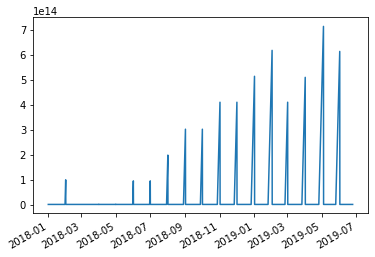

In [17]:
timme_df = time_steps(clean_df)

In [18]:
timme_df[timme_df.time_delta > dt.timedelta(minutes = 10)]

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,date_by_hour,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,...,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation,time_delta
2018-02-01 03:20:00,0.470467,0.614612,0.144145,2018-02-01 04:00:00+01:00,0.0,13.055804,656.781130,99372.96250,1.076438,0.003659,...,54.056635,66.703767,11.334257,6.159610,11.247049,16.504561,2018-01-31 18:00:00+00:00,70.030037,-37.518097,1 days 03:30:00
2018-03-31 22:00:00,0.069826,0.075014,0.005188,2018-04-01 00:00:00+02:00,0.0,8.546135,498.243667,100331.73125,0.482458,0.003673,...,223.084107,237.459306,6.959309,3.678809,6.747571,11.209571,2018-03-31 12:00:00+00:00,335.011475,-32.400940,0 days 00:20:00
2018-04-30 22:00:00,0.163683,0.192346,0.028663,2018-05-01 00:00:00+02:00,7.5,9.281732,224.865671,100035.90000,2.209233,0.005903,...,95.734538,21.284337,8.289386,3.730394,8.118580,14.208779,2018-04-30 12:00:00+00:00,339.876373,-22.471024,0 days 00:20:00
2018-06-01 02:10:00,0.127864,0.146984,0.019120,2018-06-01 04:00:00+02:00,0.0,7.192271,169.538750,101599.78125,1.918500,0.008660,...,267.815913,314.118100,7.105977,3.314000,6.899839,6.156615,2018-05-31 18:00:00+00:00,37.581707,-9.007782,1 days 02:20:00
2018-07-01 02:10:00,0.052906,0.068404,0.015498,2018-07-01 04:00:00+02:00,0.0,3.902580,71.605608,102206.60000,3.120614,0.006845,...,308.735580,307.905307,5.560496,2.467568,5.515304,4.467685,2018-06-30 18:00:00+00:00,35.783306,-8.196304,1 days 02:20:00
2018-08-01 06:50:00,0.001015,0.002272,0.001257,2018-08-01 08:00:00+02:00,198.0,3.008264,260.058220,102080.63750,-0.452029,0.010370,...,141.388874,91.763758,2.741756,1.925532,2.768492,4.222563,2018-08-01 00:00:00+00:00,84.547691,19.583670,2 days 07:00:00
2018-09-01 11:40:00,0.024328,0.029078,0.004750,2018-09-01 13:00:00+02:00,680.0,3.393276,1094.583081,102616.02500,-1.413082,0.007062,...,148.850382,149.585834,3.520197,2.935550,3.469694,3.757055,2018-09-01 00:00:00+00:00,172.131439,47.644485,3 days 11:50:00
2018-10-01 11:40:00,0.211380,0.221672,0.010292,2018-10-01 13:00:00+02:00,400.0,8.600000,1171.137249,101299.85625,-0.750265,0.005723,...,130.520918,133.300833,8.795283,6.404040,8.675665,10.627143,2018-10-01 00:00:00+00:00,176.638840,36.430210,3 days 11:50:00
2018-11-01 17:40:00,0.070643,0.075330,0.004687,2018-11-01 18:00:00+01:00,0.0,6.660860,217.007751,100957.87500,1.327958,0.006109,...,323.810616,266.085509,6.199340,2.774504,6.082159,7.098012,2018-11-01 06:00:00+00:00,260.382812,-10.220027,4 days 17:50:00
2018-12-01 17:40:00,0.264917,0.272615,0.007698,2018-12-01 18:00:00+01:00,17.5,10.856519,529.806914,100908.99375,0.779986,0.005513,...,15.067707,41.172480,8.460782,4.335163,8.266468,13.404292,2018-12-01 06:00:00+00:00,254.357437,-15.212495,4 days 17:50:00


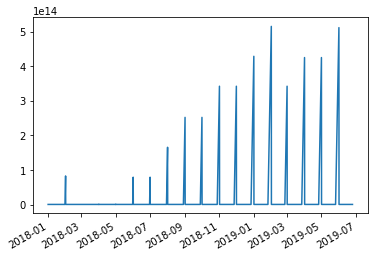

In [19]:
dummy_df = time_steps(nrg_df)

In [20]:
dummy_df[dummy_df.time_delta > dt.timedelta(minutes = 10)]

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,date_by_hour,time_delta
2018-01-31 22:50:00,0.504521,0.628009,0.123488,2018-01-31 23:00:00+01:00,0 days 23:00:00
2018-03-31 22:00:00,0.069826,0.075014,0.005188,2018-04-01 00:00:00+02:00,0 days 00:20:00
2018-04-30 22:00:00,0.163683,0.192346,0.028663,2018-05-01 00:00:00+02:00,0 days 00:20:00
2018-05-31 21:50:00,0.208707,0.240860,0.032153,2018-05-31 23:00:00+02:00,0 days 22:00:00
2018-06-30 21:50:00,0.050557,0.083927,0.033370,2018-06-30 23:00:00+02:00,0 days 22:00:00
2018-07-31 21:50:00,0.051874,0.082755,0.030882,2018-07-31 23:00:00+02:00,1 days 22:00:00
2018-08-31 21:50:00,0.064814,0.094250,0.029436,2018-08-31 23:00:00+02:00,2 days 22:00:00
2018-09-30 21:50:00,0.013319,0.021288,0.007969,2018-09-30 23:00:00+02:00,2 days 22:00:00
2018-10-31 22:50:00,0.226518,0.235331,0.008813,2018-10-31 23:00:00+01:00,3 days 23:00:00
2018-11-30 22:50:00,0.353818,0.397405,0.043587,2018-11-30 23:00:00+01:00,3 days 23:00:00


Filling gaps

In [21]:
complete_index = pd.date_range(clean_df.index[0], clean_df.index[-1], freq='10min')

In [22]:
complete_index

DatetimeIndex(['2018-01-01 06:00:00', '2018-01-01 06:10:00',
               '2018-01-01 06:20:00', '2018-01-01 06:30:00',
               '2018-01-01 06:40:00', '2018-01-01 06:50:00',
               '2018-01-01 07:00:00', '2018-01-01 07:10:00',
               '2018-01-01 07:20:00', '2018-01-01 07:30:00',
               ...
               '2019-06-24 22:20:00', '2019-06-24 22:30:00',
               '2019-06-24 22:40:00', '2019-06-24 22:50:00',
               '2019-06-24 23:00:00', '2019-06-24 23:10:00',
               '2019-06-24 23:20:00', '2019-06-24 23:30:00',
               '2019-06-24 23:40:00', '2019-06-24 23:50:00'],
              dtype='datetime64[ns]', length=77724, freq='10T')

In [23]:
clean_df = backup_clean_df.copy()

In [24]:
clean_df = clean_df.resample('10min').pad()

Timedelta('0 days 00:10:00')

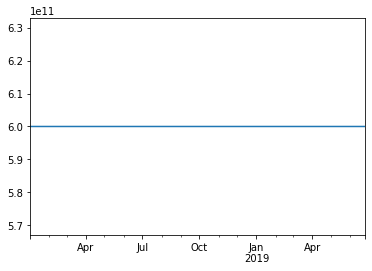

In [25]:
clean_df = time_steps(clean_df)
min(clean_df[1:].time_delta)

In [26]:
clean_df.index

DatetimeIndex(['2018-01-01 06:00:00', '2018-01-01 06:10:00',
               '2018-01-01 06:20:00', '2018-01-01 06:30:00',
               '2018-01-01 06:40:00', '2018-01-01 06:50:00',
               '2018-01-01 07:00:00', '2018-01-01 07:10:00',
               '2018-01-01 07:20:00', '2018-01-01 07:30:00',
               ...
               '2019-06-24 22:20:00', '2019-06-24 22:30:00',
               '2019-06-24 22:40:00', '2019-06-24 22:50:00',
               '2019-06-24 23:00:00', '2019-06-24 23:10:00',
               '2019-06-24 23:20:00', '2019-06-24 23:30:00',
               '2019-06-24 23:40:00', '2019-06-24 23:50:00'],
              dtype='datetime64[ns]', length=77724, freq='10T')

# EDA

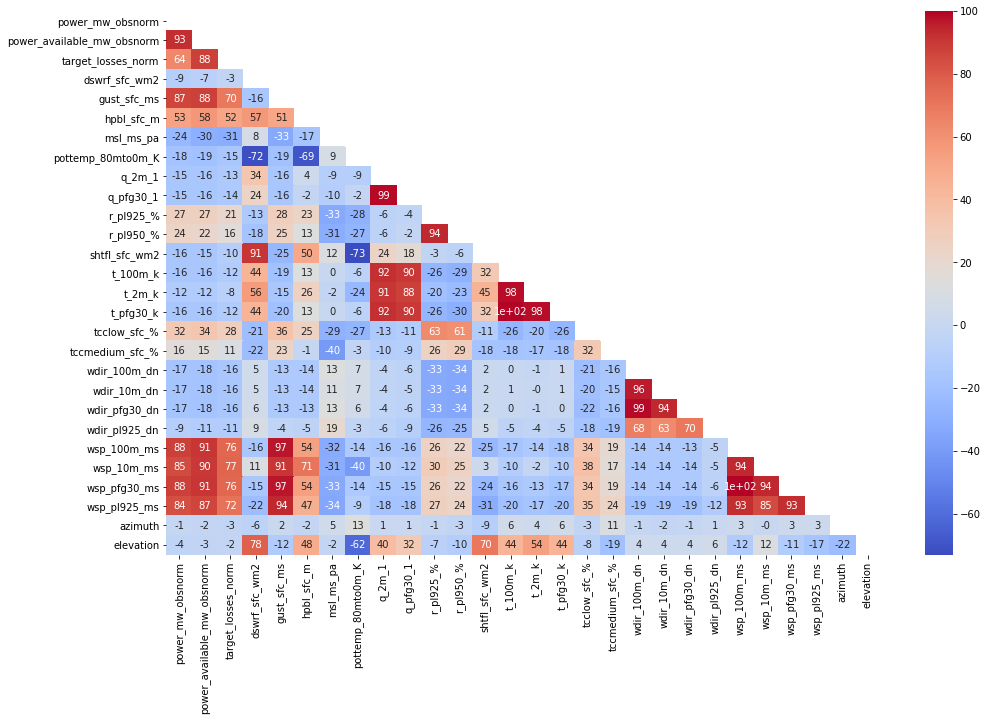

In [27]:
mask = np.triu(clean_df.corr())
plt.figure(figsize = (16,10))
ax = sns.heatmap(round(clean_df.corr()*100,0)
                 ,annot=True
                 ,mask=mask
                 ,cmap='coolwarm')

Since it takes quite some time to plot, we will import the results of the pair plot: 
![Pairplot](figures/pairplot.png)

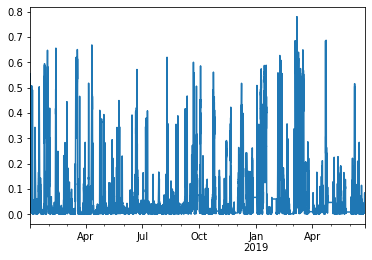

In [28]:
clean_df.target_losses_norm.plot()

In [29]:
loss_above_p = {}
max_loss = max(nrg_df.target_losses_norm)
for p in range(0, 100):
    loss_above_p[p] = nrg_df[nrg_df.target_losses_norm >= max_loss * p /100].shape[0]

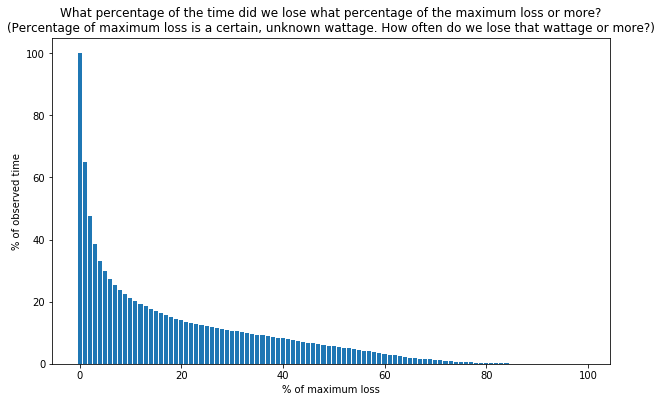

In [30]:
loss_above_p_ratio = {k: v*100/nrg_df.shape[0] for k,v in enumerate(loss_above_p.values())}
plt.figure(figsize = (10,6))
plt.bar(loss_above_p.keys(), loss_above_p_ratio.values())
plt.ylabel('% of observed time')
plt.xlabel('% of maximum loss')
plt.title('What percentage of the time did we lose what percentage of the maximum loss or more?\n(Percentage of maximum loss is a certain, unknown wattage. How often do we lose that wattage or more?)')

plt.savefig('figures/percent_of_time_over_p_of_loss')

In [31]:
loss_p_ratio = dict(enumerate(np.diff(list(loss_above_p_ratio.values()))*(-1)))

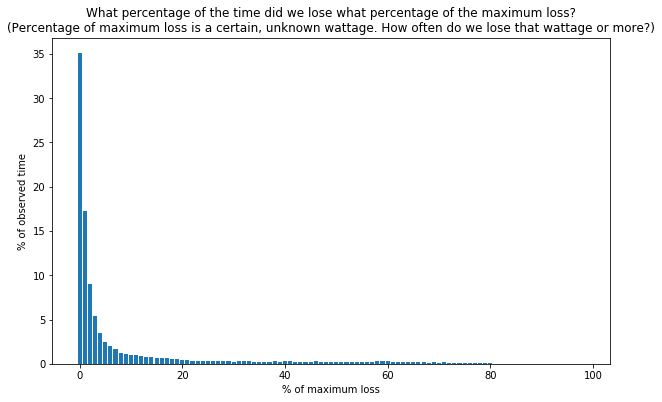

In [32]:
plt.figure(figsize = (10,6))
plt.bar(loss_p_ratio.keys(), loss_p_ratio.values())
plt.ylabel('% of observed time')
plt.xlabel('% of maximum loss')
plt.title('What percentage of the time did we lose what percentage of the maximum loss?\n(Percentage of maximum loss is a certain, unknown wattage. How often do we lose that wattage or more?)')

plt.savefig('figures/percent_of_time_over_p_of_loss')

In [33]:
lpr_log = dict(enumerate(np.log(list(loss_p_ratio.values()))))

C:\Users\thoma\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


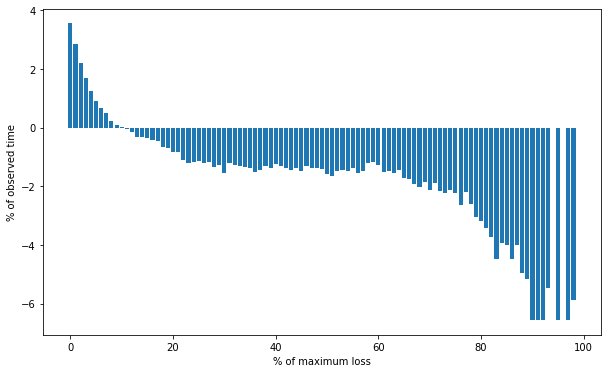

In [34]:
plt.figure(figsize = (10,6))
plt.bar(lpr_log.keys(), lpr_log.values())
plt.ylabel('% of observed time')
plt.xlabel('% of maximum loss')
plt.title('')

plt.savefig('figures/percent_of_time_over_p_of_loss')

In [35]:
lpr_log_log = dict(enumerate(np.log([t for t in lpr_log.values() if t>=1])))

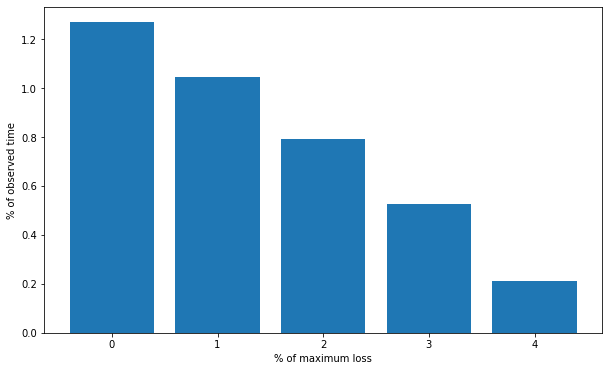

In [36]:
plt.figure(figsize = (10,6))
plt.bar(lpr_log_log.keys(), lpr_log_log.values())
plt.ylabel('% of observed time')
plt.xlabel('% of maximum loss')
plt.title('')

plt.savefig('figures/percent_of_time_over_p_of_loss')


# Prediction

## Preparing the train/test split

In [37]:
date_list = pd.date_range(clean_df.index[0], clean_df.index[-1], freq='6H')

In [38]:
date_list

DatetimeIndex(['2018-01-01 06:00:00', '2018-01-01 12:00:00',
               '2018-01-01 18:00:00', '2018-01-02 00:00:00',
               '2018-01-02 06:00:00', '2018-01-02 12:00:00',
               '2018-01-02 18:00:00', '2018-01-03 00:00:00',
               '2018-01-03 06:00:00', '2018-01-03 12:00:00',
               ...
               '2019-06-22 12:00:00', '2019-06-22 18:00:00',
               '2019-06-23 00:00:00', '2019-06-23 06:00:00',
               '2019-06-23 12:00:00', '2019-06-23 18:00:00',
               '2019-06-24 00:00:00', '2019-06-24 06:00:00',
               '2019-06-24 12:00:00', '2019-06-24 18:00:00'],
              dtype='datetime64[ns]', length=2159, freq='6H')

In [39]:
def model_applyer(model, lag = 36):

    test_values, results = [], []

    for i in range(2+(lag/36), len(date_list)):
        train_frame =(clean_df.index >= date_list[int(lag/36)+1]) & (clean_df.index < date_list[i-1])
        test_frame = (clean_df.index >= date_list[i-1]) & (clean_df.index < date_list[i])

        df = clean_df[wthr_columns].shift(lag)[train_frame]
        df['target_losses_norm'] = list(clean_df.target_losses_norm[train_frame])

        test_values.append(clean_df.target_losses_norm[test_frame])
        results.append(mean(naive_model_pred(df)))
        
        return results, test_values

In [40]:
clean_df[clean_df.index =='2018-01-01 12:00:00']

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,date_by_hour,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,...,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation,time_delta
2018-01-01 12:00:00,0.561785,0.910409,0.348623,2018-01-01 13:00:00+01:00,97.5,15.498557,1464.66772,99657.975,0.202019,0.004578,...,63.024267,67.200959,14.916884,9.337325,14.561644,19.715329,2018-01-01 06:00:00+00:00,189.105545,15.42164,00:10:00


In [41]:
sd = seasonal_decompose(clean_df.target_losses_norm, period = 6*24) #, model = 'multiplicative'

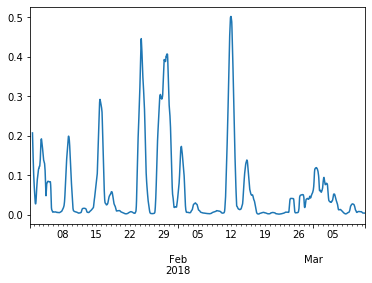

In [42]:
sd.trend[:10000].plot()

## Naive model

In [177]:
def naive_model_applyer( lag = 36):

    test_values, results = [], []

    for i in range(2+int(lag/36), len(date_list)):
        train_frame =(clean_df.index >= date_list[int(lag/36)+1]) & (clean_df.index < date_list[i-1])
        test_frame = (clean_df.index >= date_list[i-1]) & (clean_df.index < date_list[i])

        df = clean_df[wthr_columns].shift(lag)[train_frame]
        df['target_losses_norm'] = list(clean_df.target_losses_norm[train_frame])
        
        result = naive_model_pred(df)
        if result == None:    
            continue
        
        test_value = clean_df.target_losses_norm[test_frame]
        if len(test_value) < lag:
            continue
            
        results.append(result)
        test_values.append(test_value)
        
        
    return results, test_values

In [178]:
def naive_model_pred(df, season=6*24):
    '''
    returns the value of on season before
    '''
    if df.shape[0] >= season+36:
        return list(list(df.target_losses_norm)[-(season+36):-season])
    else:
        print('Not enough time in DataFrame')
        return None

In [179]:
results, test = naive_model_applyer()

Not enough time in DataFrame
Not enough time in DataFrame
Not enough time in DataFrame
Not enough time in DataFrame
Not enough time in DataFrame


In [177]:
plt.plot([mean(i) for i in results])
plt.plot([mean(i) for i in test])
plt.legend(labels = ['predicted','true'])
plt.show

NameError: name 'results' is not defined

In [138]:
def regr_eval(y_test, y_pred, return_scores=False, print_scores=True):
    if print_scores==True:
        print('Mean squared error: '+str(round(mean_squared_error(y_test, y_pred),6)))
        print('Root mean squared error: '+str(round(np.sqrt(mean_squared_error(y_test, y_pred)),6)))
        print('Explained variance score: '+str(round(explained_variance_score(y_test, y_pred),6)))
        print('R-squared score: '+str(round(r2_score(y_test, y_pred),6)))
    if return_scores==True:
        return mean_squared_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)), explained_variance_score(y_test, y_pred), r2_score(y_test, y_pred)

In [183]:
naive_r2 = list()
for i in range(len(results)):
    naive_r2.append(r2_score(test[i], results[i]))

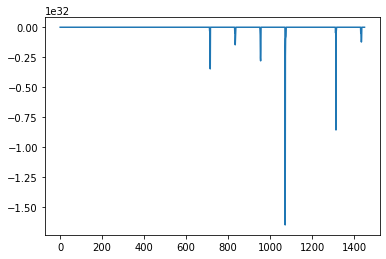

In [184]:
plt.plot(naive_r2)

In [49]:
pd.DataFrame(data = {'prediction' : results, 'true' : [y[-1] for y in test]})

,prediction,true
0,"[0.21358356635835662, 0.21672445687244568, 0.2...",0.121707
1,"[0.01546999354699935, 0.013682942568294248, 0....",0.086370
2,"[0.012980425898042602, 0.01568767476876748, 0....",0.049786
3,"[0.047202409120240985, 0.05085953968595397, 0....",0.427590
4,"[0.021570445257044546, 0.01990729189072915, 0....",0.012396
...,...,...
1895,"[0.0023397724833655294, 0.003557115260785575, ...",0.021251
1896,"[0.003175574157544537, 0.0024069542820347707, ...",0.026207
1897,"[0.00489169349645846, 0.0060327194676969426, 0...",0.005183
1898,"[0.009933736853402042, 0.011280051513200273, 0...",0.021249


In [51]:
test[-1]

2019-06-24 12:00:00    0.027688
2019-06-24 12:10:00    0.028970
2019-06-24 12:20:00    0.022517
2019-06-24 12:30:00    0.028744
2019-06-24 12:40:00    0.023548
2019-06-24 12:50:00    0.025394
2019-06-24 13:00:00    0.021545
2019-06-24 13:10:00    0.027957
2019-06-24 13:20:00    0.032782
2019-06-24 13:30:00    0.034375
2019-06-24 13:40:00    0.057281
2019-06-24 13:50:00    0.061849
2019-06-24 14:00:00    0.066355
2019-06-24 14:10:00    0.062974
2019-06-24 14:20:00    0.072380
2019-06-24 14:30:00    0.075124
2019-06-24 14:40:00    0.076537
2019-06-24 14:50:00    0.071641
2019-06-24 15:00:00    0.077447
2019-06-24 15:10:00    0.075630
2019-06-24 15:20:00    0.084865
2019-06-24 15:30:00    0.081960
2019-06-24 15:40:00    0.082407
2019-06-24 15:50:00    0.075286
2019-06-24 16:00:00    0.067420
2019-06-24 16:10:00    0.055149
2019-06-24 16:20:00    0.034440
2019-06-24 16:30:00    0.031163
2019-06-24 16:40:00    0.028720
2019-06-24 16:50:00    0.022848
2019-06-24 17:00:00    0.021949
2019-06-

## ARIMA Model

Time to try the arima model.

### Test for stationarity

In [88]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=36).mean()
    rolling_std = timeseries.rolling(window=36).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

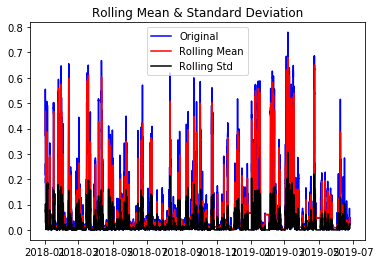

ADF Statistic: -14.682729069326008
p-value: 3.1375615972323714e-27
Critical Values:
	1%: -3.4304342080913126
	5%: -2.861577218539088
	10%: -2.5667898101465503


In [89]:
get_stationarity(clean_df.target_losses_norm)

With these values, it is safe to assume, that the time series is stationary. More infos [here](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/ "Article about ADF at Machine Learning Plus").  
We can apply an ARIMA analysis only on stationary time series.

In [90]:
clean_df[(clean_df.index >= date_list[9+1]) & (clean_df.index < date_list[9+2])]

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,date_by_hour,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,...,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation,time_delta
2018-01-03 18:00:00,0.550041,0.612656,0.062616,2018-01-03 19:00:00+01:00,15.0,15.437522,983.147368,98028.70625,0.644024,0.005288,...,100.985274,105.311293,14.111062,8.262144,14.691671,19.380456,2018-01-03 12:00:00+00:00,261.589661,-23.095095,00:10:00
2018-01-03 18:10:00,0.578314,0.659056,0.080743,2018-01-03 19:00:00+01:00,15.0,15.437522,983.147368,98028.70625,0.644024,0.005288,...,100.985274,105.311293,14.111062,8.262144,14.691671,19.380456,2018-01-03 12:00:00+00:00,261.589661,-23.095095,00:10:00
2018-01-03 18:20:00,0.540305,0.692412,0.152107,2018-01-03 19:00:00+01:00,15.0,15.437522,983.147368,98028.70625,0.644024,0.005288,...,100.985274,105.311293,14.111062,8.262144,14.691671,19.380456,2018-01-03 12:00:00+00:00,261.589661,-23.095095,00:10:00
2018-01-03 18:30:00,0.559914,0.715180,0.155266,2018-01-03 19:00:00+01:00,15.0,15.437522,983.147368,98028.70625,0.644024,0.005288,...,100.985274,105.311293,14.111062,8.262144,14.691671,19.380456,2018-01-03 12:00:00+00:00,261.589661,-23.095095,00:10:00
2018-01-03 18:40:00,0.586393,0.738188,0.151795,2018-01-03 19:00:00+01:00,15.0,15.437522,983.147368,98028.70625,0.644024,0.005288,...,100.985274,105.311293,14.111062,8.262144,14.691671,19.380456,2018-01-03 12:00:00+00:00,261.589661,-23.095095,00:10:00
2018-01-03 18:50:00,0.594558,0.740560,0.146002,2018-01-03 19:00:00+01:00,15.0,15.437522,983.147368,98028.70625,0.644024,0.005288,...,100.985274,105.311293,14.111062,8.262144,14.691671,19.380456,2018-01-03 12:00:00+00:00,261.589661,-23.095095,00:10:00
2018-01-03 19:00:00,0.563571,0.724208,0.160637,2018-01-03 20:00:00+01:00,0.0,17.087549,1180.843726,98093.87500,0.480855,0.005258,...,103.530155,106.626706,16.030580,9.683557,16.597057,21.529050,2018-01-03 12:00:00+00:00,272.985901,-32.460770,00:10:00
2018-01-03 19:10:00,0.550437,0.714251,0.163814,2018-01-03 20:00:00+01:00,0.0,17.087549,1180.843726,98093.87500,0.480855,0.005258,...,103.530155,106.626706,16.030580,9.683557,16.597057,21.529050,2018-01-03 12:00:00+00:00,272.985901,-32.460770,00:10:00
2018-01-03 19:20:00,0.588866,0.739501,0.150635,2018-01-03 20:00:00+01:00,0.0,17.087549,1180.843726,98093.87500,0.480855,0.005258,...,103.530155,106.626706,16.030580,9.683557,16.597057,21.529050,2018-01-03 12:00:00+00:00,272.985901,-32.460770,00:10:00
2018-01-03 19:30:00,0.642762,0.787325,0.144563,2018-01-03 20:00:00+01:00,0.0,17.087549,1180.843726,98093.87500,0.480855,0.005258,...,103.530155,106.626706,16.030580,9.683557,16.597057,21.529050,2018-01-03 12:00:00+00:00,272.985901,-32.460770,00:10:00


### Applying Arima Model

In [91]:
date_list = pd.date_range(clean_df.index[0], clean_df.index[clean_df.index.year == 2018 ][-1], freq='6H')

In [92]:
date_list[-1]

Timestamp('2018-12-31 18:00:00', freq='6H')

In [93]:
clean_df.index[0]

Timestamp('2018-01-01 06:00:00', freq='10T')

In [94]:
def add_freq(idx, freq=None):
    """Add a frequency attribute to idx, through inference or directly.

    Returns a copy.  If `freq` is None, it is inferred.
    """

    idx = idx.copy()
    if freq is None:
        if idx.freq is None:
            freq = pd.infer_freq(idx)
        else:
            return idx
    idx.freq = pd.tseries.frequencies.to_offset(freq)
    if idx.freq is None:
        raise AttributeError('no discernible frequency found to `idx`.  Specify'
                             ' a frequency string with `freq`.')
    return idx

In [148]:
def arima_model_applier(df, order=(1,1,1), lag = 6*6, six_hour_steps_back = 4*30):
    
    test_values, results = [], []
    
    
    for i in range(2+int(lag/36), len(date_list)):
        print(str(i) + ' of ' + str(len(date_list)))
        train_frame =(df.index >= date_list[max([int(lag/36)+1, i - (six_hour_steps_back)])]) & (df.index < date_list[i-1])
        test_frame = (df.index >= date_list[i-1]) & (df.index < date_list[i])
        
        if not any(train_frame):
            continue
            
        df_train = df[wthr_columns].shift(lag)[train_frame]
        df_train['target_losses_norm'] = list(df.target_losses_norm[train_frame])
        
        model = ARIMA(df_train.target_losses_norm, order=order)
        
        result = model.fit(disp=-1)
        if result == None:    
            continue
        
        test_value = clean_df.target_losses_norm[test_frame]
        if len(test_value) < lag:
            continue
            
        results.append(result)
        test_values.append(test_value)
        
        
    return results, test_values

In [186]:
arima_results, arima_test = arima_model_applier(clean_df.copy())

3 of 1459
4 of 1459
5 of 1459
6 of 1459
7 of 1459
8 of 1459
9 of 1459
10 of 1459
11 of 1459
12 of 1459
13 of 1459
14 of 1459
15 of 1459
16 of 1459
17 of 1459
18 of 1459
19 of 1459
20 of 1459
21 of 1459
22 of 1459
23 of 1459
24 of 1459
25 of 1459
26 of 1459
27 of 1459
28 of 1459
29 of 1459
30 of 1459
31 of 1459
32 of 1459
33 of 1459
34 of 1459
35 of 1459
36 of 1459
37 of 1459
38 of 1459
39 of 1459
40 of 1459
41 of 1459
42 of 1459
43 of 1459
44 of 1459
45 of 1459
46 of 1459
47 of 1459
48 of 1459
49 of 1459
50 of 1459
51 of 1459
52 of 1459
53 of 1459
54 of 1459
55 of 1459
56 of 1459
57 of 1459
58 of 1459
59 of 1459
60 of 1459
61 of 1459
62 of 1459
63 of 1459
64 of 1459
65 of 1459
66 of 1459
67 of 1459
68 of 1459
69 of 1459
70 of 1459
71 of 1459
72 of 1459
73 of 1459
74 of 1459
75 of 1459
76 of 1459
77 of 1459
78 of 1459
79 of 1459
80 of 1459
81 of 1459
82 of 1459
83 of 1459
84 of 1459
85 of 1459
86 of 1459
87 of 1459
88 of 1459
89 of 1459
90 of 1459
91 of 1459
92 of 1459
93 of 1459
94 of 

C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


153 of 1459
154 of 1459
155 of 1459
156 of 1459
157 of 1459
158 of 1459
159 of 1459
160 of 1459
161 of 1459
162 of 1459
163 of 1459
164 of 1459
165 of 1459
166 of 1459
167 of 1459
168 of 1459
169 of 1459
170 of 1459
171 of 1459
172 of 1459
173 of 1459
174 of 1459
175 of 1459
176 of 1459
177 of 1459
178 of 1459
179 of 1459
180 of 1459
181 of 1459
182 of 1459
183 of 1459
184 of 1459
185 of 1459
186 of 1459
187 of 1459
188 of 1459
189 of 1459
190 of 1459
191 of 1459
192 of 1459
193 of 1459
194 of 1459
195 of 1459
196 of 1459
197 of 1459
198 of 1459
199 of 1459
200 of 1459
201 of 1459
202 of 1459
203 of 1459
204 of 1459
205 of 1459
206 of 1459
207 of 1459
208 of 1459
209 of 1459
210 of 1459
211 of 1459
212 of 1459
213 of 1459
214 of 1459
215 of 1459
216 of 1459
217 of 1459
218 of 1459
219 of 1459
220 of 1459
221 of 1459
222 of 1459
223 of 1459
224 of 1459
225 of 1459
226 of 1459
227 of 1459
228 of 1459
229 of 1459
230 of 1459
231 of 1459
232 of 1459
233 of 1459
234 of 1459
235 of 1459
236 

C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


519 of 1459
520 of 1459
521 of 1459
522 of 1459
523 of 1459
524 of 1459
525 of 1459
526 of 1459
527 of 1459
528 of 1459
529 of 1459
530 of 1459
531 of 1459
532 of 1459
533 of 1459
534 of 1459
535 of 1459
536 of 1459
537 of 1459
538 of 1459
539 of 1459
540 of 1459
541 of 1459
542 of 1459
543 of 1459
544 of 1459
545 of 1459
546 of 1459
547 of 1459
548 of 1459
549 of 1459
550 of 1459
551 of 1459
552 of 1459
553 of 1459
554 of 1459
555 of 1459
556 of 1459
557 of 1459
558 of 1459
559 of 1459
560 of 1459
561 of 1459
562 of 1459
563 of 1459
564 of 1459
565 of 1459
566 of 1459
567 of 1459
568 of 1459
569 of 1459


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


570 of 1459
571 of 1459
572 of 1459
573 of 1459
574 of 1459
575 of 1459
576 of 1459
577 of 1459
578 of 1459
579 of 1459
580 of 1459
581 of 1459
582 of 1459
583 of 1459
584 of 1459
585 of 1459
586 of 1459
587 of 1459
588 of 1459
589 of 1459
590 of 1459
591 of 1459
592 of 1459
593 of 1459
594 of 1459
595 of 1459
596 of 1459
597 of 1459
598 of 1459
599 of 1459
600 of 1459
601 of 1459
602 of 1459
603 of 1459
604 of 1459
605 of 1459
606 of 1459
607 of 1459
608 of 1459
609 of 1459
610 of 1459
611 of 1459
612 of 1459
613 of 1459
614 of 1459
615 of 1459
616 of 1459
617 of 1459
618 of 1459
619 of 1459
620 of 1459
621 of 1459
622 of 1459
623 of 1459
624 of 1459
625 of 1459
626 of 1459
627 of 1459
628 of 1459
629 of 1459
630 of 1459
631 of 1459
632 of 1459
633 of 1459
634 of 1459
635 of 1459
636 of 1459
637 of 1459
638 of 1459
639 of 1459
640 of 1459
641 of 1459
642 of 1459
643 of 1459
644 of 1459
645 of 1459
646 of 1459
647 of 1459
648 of 1459
649 of 1459
650 of 1459
651 of 1459
652 of 1459
653 

C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


684 of 1459
685 of 1459


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


686 of 1459
687 of 1459
688 of 1459
689 of 1459
690 of 1459
691 of 1459
692 of 1459
693 of 1459
694 of 1459
695 of 1459
696 of 1459
697 of 1459
698 of 1459
699 of 1459
700 of 1459
701 of 1459
702 of 1459
703 of 1459
704 of 1459
705 of 1459
706 of 1459
707 of 1459
708 of 1459
709 of 1459
710 of 1459
711 of 1459
712 of 1459
713 of 1459
714 of 1459
715 of 1459
716 of 1459
717 of 1459
718 of 1459
719 of 1459
720 of 1459
721 of 1459
722 of 1459
723 of 1459
724 of 1459
725 of 1459
726 of 1459
727 of 1459
728 of 1459
729 of 1459
730 of 1459
731 of 1459
732 of 1459
733 of 1459
734 of 1459
735 of 1459
736 of 1459
737 of 1459
738 of 1459
739 of 1459
740 of 1459
741 of 1459
742 of 1459
743 of 1459
744 of 1459
745 of 1459
746 of 1459
747 of 1459
748 of 1459
749 of 1459
750 of 1459
751 of 1459
752 of 1459
753 of 1459
754 of 1459
755 of 1459
756 of 1459
757 of 1459
758 of 1459
759 of 1459
760 of 1459
761 of 1459
762 of 1459
763 of 1459
764 of 1459
765 of 1459
766 of 1459
767 of 1459
768 of 1459
769 

C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


821 of 1459
822 of 1459
823 of 1459
824 of 1459
825 of 1459
826 of 1459
827 of 1459
828 of 1459
829 of 1459
830 of 1459
831 of 1459
832 of 1459
833 of 1459
834 of 1459
835 of 1459
836 of 1459
837 of 1459
838 of 1459
839 of 1459
840 of 1459
841 of 1459
842 of 1459
843 of 1459
844 of 1459
845 of 1459
846 of 1459
847 of 1459
848 of 1459
849 of 1459
850 of 1459
851 of 1459
852 of 1459
853 of 1459
854 of 1459
855 of 1459
856 of 1459
857 of 1459
858 of 1459
859 of 1459
860 of 1459
861 of 1459
862 of 1459
863 of 1459
864 of 1459
865 of 1459
866 of 1459
867 of 1459


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


868 of 1459
869 of 1459
870 of 1459
871 of 1459
872 of 1459
873 of 1459
874 of 1459
875 of 1459
876 of 1459
877 of 1459
878 of 1459
879 of 1459
880 of 1459
881 of 1459
882 of 1459
883 of 1459
884 of 1459
885 of 1459
886 of 1459
887 of 1459
888 of 1459
889 of 1459
890 of 1459
891 of 1459
892 of 1459
893 of 1459
894 of 1459
895 of 1459
896 of 1459
897 of 1459
898 of 1459
899 of 1459
900 of 1459
901 of 1459
902 of 1459
903 of 1459
904 of 1459
905 of 1459
906 of 1459
907 of 1459
908 of 1459
909 of 1459
910 of 1459
911 of 1459
912 of 1459
913 of 1459
914 of 1459
915 of 1459
916 of 1459
917 of 1459
918 of 1459
919 of 1459
920 of 1459
921 of 1459
922 of 1459
923 of 1459
924 of 1459
925 of 1459
926 of 1459
927 of 1459
928 of 1459
929 of 1459
930 of 1459
931 of 1459
932 of 1459
933 of 1459
934 of 1459
935 of 1459
936 of 1459
937 of 1459
938 of 1459
939 of 1459
940 of 1459
941 of 1459
942 of 1459
943 of 1459
944 of 1459
945 of 1459
946 of 1459
947 of 1459
948 of 1459
949 of 1459
950 of 1459
951 

C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


997 of 1459
998 of 1459
999 of 1459
1000 of 1459
1001 of 1459
1002 of 1459
1003 of 1459
1004 of 1459
1005 of 1459
1006 of 1459
1007 of 1459
1008 of 1459
1009 of 1459
1010 of 1459
1011 of 1459
1012 of 1459
1013 of 1459
1014 of 1459
1015 of 1459
1016 of 1459
1017 of 1459
1018 of 1459
1019 of 1459
1020 of 1459
1021 of 1459
1022 of 1459
1023 of 1459
1024 of 1459
1025 of 1459
1026 of 1459
1027 of 1459
1028 of 1459
1029 of 1459
1030 of 1459
1031 of 1459
1032 of 1459
1033 of 1459
1034 of 1459
1035 of 1459
1036 of 1459
1037 of 1459
1038 of 1459
1039 of 1459
1040 of 1459
1041 of 1459
1042 of 1459
1043 of 1459
1044 of 1459
1045 of 1459
1046 of 1459
1047 of 1459
1048 of 1459
1049 of 1459
1050 of 1459
1051 of 1459
1052 of 1459
1053 of 1459
1054 of 1459
1055 of 1459
1056 of 1459
1057 of 1459
1058 of 1459
1059 of 1459
1060 of 1459
1061 of 1459
1062 of 1459
1063 of 1459
1064 of 1459
1065 of 1459
1066 of 1459
1067 of 1459


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1068 of 1459
1069 of 1459
1070 of 1459
1071 of 1459
1072 of 1459
1073 of 1459
1074 of 1459
1075 of 1459
1076 of 1459
1077 of 1459
1078 of 1459
1079 of 1459
1080 of 1459
1081 of 1459
1082 of 1459
1083 of 1459
1084 of 1459
1085 of 1459
1086 of 1459
1087 of 1459
1088 of 1459
1089 of 1459
1090 of 1459
1091 of 1459
1092 of 1459
1093 of 1459
1094 of 1459
1095 of 1459
1096 of 1459
1097 of 1459
1098 of 1459
1099 of 1459
1100 of 1459
1101 of 1459
1102 of 1459
1103 of 1459
1104 of 1459
1105 of 1459
1106 of 1459
1107 of 1459
1108 of 1459
1109 of 1459
1110 of 1459
1111 of 1459
1112 of 1459
1113 of 1459
1114 of 1459
1115 of 1459
1116 of 1459
1117 of 1459
1118 of 1459
1119 of 1459
1120 of 1459
1121 of 1459
1122 of 1459
1123 of 1459
1124 of 1459
1125 of 1459
1126 of 1459
1127 of 1459
1128 of 1459
1129 of 1459
1130 of 1459
1131 of 1459
1132 of 1459
1133 of 1459
1134 of 1459
1135 of 1459


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1136 of 1459
1137 of 1459
1138 of 1459
1139 of 1459
1140 of 1459
1141 of 1459
1142 of 1459
1143 of 1459
1144 of 1459
1145 of 1459
1146 of 1459
1147 of 1459
1148 of 1459
1149 of 1459
1150 of 1459
1151 of 1459
1152 of 1459
1153 of 1459
1154 of 1459
1155 of 1459
1156 of 1459
1157 of 1459
1158 of 1459
1159 of 1459
1160 of 1459
1161 of 1459
1162 of 1459
1163 of 1459
1164 of 1459
1165 of 1459
1166 of 1459
1167 of 1459
1168 of 1459
1169 of 1459
1170 of 1459
1171 of 1459
1172 of 1459
1173 of 1459
1174 of 1459
1175 of 1459
1176 of 1459
1177 of 1459
1178 of 1459
1179 of 1459
1180 of 1459
1181 of 1459
1182 of 1459
1183 of 1459
1184 of 1459
1185 of 1459
1186 of 1459
1187 of 1459
1188 of 1459
1189 of 1459
1190 of 1459
1191 of 1459
1192 of 1459
1193 of 1459
1194 of 1459
1195 of 1459
1196 of 1459
1197 of 1459
1198 of 1459
1199 of 1459
1200 of 1459
1201 of 1459
1202 of 1459
1203 of 1459
1204 of 1459
1205 of 1459
1206 of 1459
1207 of 1459
1208 of 1459
1209 of 1459
1210 of 1459
1211 of 1459
1212 of 1459

C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1220 of 1459
1221 of 1459
1222 of 1459
1223 of 1459
1224 of 1459
1225 of 1459
1226 of 1459
1227 of 1459
1228 of 1459
1229 of 1459
1230 of 1459
1231 of 1459
1232 of 1459
1233 of 1459
1234 of 1459
1235 of 1459
1236 of 1459
1237 of 1459
1238 of 1459
1239 of 1459
1240 of 1459
1241 of 1459
1242 of 1459
1243 of 1459
1244 of 1459
1245 of 1459
1246 of 1459
1247 of 1459
1248 of 1459
1249 of 1459
1250 of 1459
1251 of 1459
1252 of 1459
1253 of 1459
1254 of 1459
1255 of 1459
1256 of 1459
1257 of 1459
1258 of 1459
1259 of 1459
1260 of 1459
1261 of 1459
1262 of 1459
1263 of 1459
1264 of 1459
1265 of 1459
1266 of 1459
1267 of 1459
1268 of 1459
1269 of 1459
1270 of 1459
1271 of 1459
1272 of 1459
1273 of 1459
1274 of 1459
1275 of 1459
1276 of 1459
1277 of 1459
1278 of 1459
1279 of 1459
1280 of 1459
1281 of 1459
1282 of 1459
1283 of 1459
1284 of 1459
1285 of 1459
1286 of 1459
1287 of 1459
1288 of 1459
1289 of 1459
1290 of 1459
1291 of 1459
1292 of 1459
1293 of 1459
1294 of 1459
1295 of 1459
1296 of 1459

In [187]:
with open('files/ARIMA_results.p', 'wb') as f:
    pickle.dump(arima_results, f)

In [188]:
with open('files/ARIMA_test_values.p', 'wb') as f:
    pickle.dump(arima_test, f)

In [135]:
len(arima_test[-1])

36

In [152]:
#plt.plot(test[-100])
arima_results[-100].predict(1, 6*24*36+36)

2018-11-07 00:10:00    0.000024
2018-11-07 00:20:00    0.000222
2018-11-07 00:30:00    0.000374
2018-11-07 00:40:00   -0.000004
2018-11-07 00:50:00   -0.000420
                         ...   
2018-12-13 05:20:00    0.000024
2018-12-13 05:30:00    0.000024
2018-12-13 05:40:00    0.000024
2018-12-13 05:50:00    0.000024
2018-12-13 06:00:00    0.000024
Freq: 10T, Length: 5220, dtype: float64

In [189]:
type(arima_test[0])

pandas.core.series.Series

In [190]:
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [208]:
arima_r2 = []
for i in range(len(arima_test)):
    arima_r2.append(round(r2_score(arima_test[i] , arima_results[i].predict(1, len(arima_results[i].fittedvalues)+36)[-36:]),6))


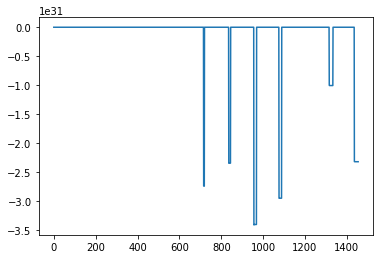

In [209]:
plt.plot(arima_r2)

In [213]:
arima_r2.index(max(arima_r2))

116

C:\Users\thoma\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\thoma\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


0.0

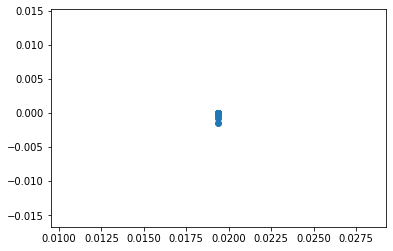

In [214]:
i = arima_r2.index(max(arima_r2))
plt.scatter(arima_test[i], arima_results[i].predict(1, len(arima_results[i].fittedvalues)+36)[-36:])
round(rsquared(arima_test[i] , arima_results[i].predict(1, len(arima_results[i].fittedvalues)+36)[-36:]),6)

<function matplotlib.pyplot.show(*args, **kw)>

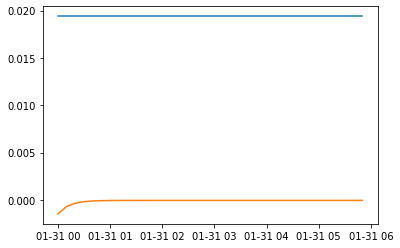

In [218]:

plt.plot(arima_test[i])
plt.plot(arima_results[i].predict(1, len(arima_results[i].fittedvalues)+36)[-36:])
plt.show

## SARIMA Model

In [43]:
date_list = pd.date_range(clean_df.index[0], clean_df.index[clean_df.index < '2018-07-01 00:00:00' ][-1], freq='6H')

In [62]:
def sarima_model_applier(df, order=(1,0,1), seasonal_order = (1,0,0,24), lag = 6, six_hour_steps_back = 5):
    
    test_values, results = [], []
    
    
    for i in range(2+int(lag/36), len(date_list)):
                
        train_frame =(df.index >= date_list[max([int(lag/36)+1, i - (six_hour_steps_back)])]) & (df.index < date_list[i-1]) & (df.index.minute == 0)
        test_frame = (df.index >= date_list[i-1]) & (df.index < date_list[i]) & (df.index.minute == 0)
        
        if not any(train_frame):
            print('No valid train_frame.')
            continue
            
        df_train = df[wthr_columns].shift(lag)[train_frame]
        df_train['target_losses_norm'] = list(df.target_losses_norm[train_frame])
        
        try:
            model = SARIMAX(df_train.target_losses_norm, order=order, seasonal_order=seasonal_order)
            result = model.fit(disp=-1)
        except Exception:
            print('Error on model.')
            continue
        
        if result == None:   
            print('No Result')
            continue
        
        test_value = clean_df.target_losses_norm[test_frame]
        if len(test_value) < lag:
            print('Test frame not long enough.')
            continue
            
        print(str(i) + ' of ' + str(len(date_list)))
        results.append(result)
        test_values.append(test_value)
        
        
    return results, test_values

In [63]:
sarima_results, sarima_test = sarima_model_applier(clean_df.copy())

No valid train_frame.


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


3 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


6 of 723
7 of 723
8 of 723
9 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


10 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


11 of 723
12 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


13 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


14 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


15 of 723
16 of 723
17 of 723
18 of 723
19 of 723
20 of 723
21 of 723
22 of 723
23 of 723
24 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


25 of 723
26 of 723
27 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


28 of 723
29 of 723
30 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


31 of 723
32 of 723
33 of 723
Error on model.


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


35 of 723
36 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


37 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


38 of 723
39 of 723
40 of 723
41 of 723
42 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


43 of 723
44 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


45 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


46 of 723
47 of 723
48 of 723
49 of 723
50 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


51 of 723
52 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


53 of 723
54 of 723
55 of 723
56 of 723
57 of 723
58 of 723
59 of 723
60 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


61 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


62 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


63 of 723
64 of 723
65 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


66 of 723
67 of 723
68 of 723
69 of 723
70 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


71 of 723
72 of 723
73 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


74 of 723
75 of 723
76 of 723
77 of 723
78 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


79 of 723
80 of 723
81 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


82 of 723
83 of 723
84 of 723
85 of 723
86 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


87 of 723
88 of 723
89 of 723
90 of 723
91 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


92 of 723
93 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


94 of 723
95 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


96 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


97 of 723
98 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


99 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


100 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


101 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


102 of 723
103 of 723
104 of 723
105 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


106 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


107 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


108 of 723
109 of 723
110 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


111 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


112 of 723
113 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


114 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


115 of 723
116 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


117 of 723
118 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


119 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


120 of 723
121 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


122 of 723
123 of 723
124 of 723
125 of 723
126 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


127 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


128 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


129 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


130 of 723
131 of 723
132 of 723
133 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


134 of 723
135 of 723
136 of 723
137 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


138 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


139 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


140 of 723
141 of 723
142 of 723
143 of 723
144 of 723
145 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


146 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


147 of 723
148 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


149 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


150 of 723
151 of 723
152 of 723
153 of 723
154 of 723
155 of 723
156 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


157 of 723
158 of 723
159 of 723
160 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


161 of 723
162 of 723
163 of 723
164 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


165 of 723
166 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


167 of 723
168 of 723
169 of 723
170 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


171 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


172 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


173 of 723
174 of 723
175 of 723
176 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


177 of 723
178 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


179 of 723
180 of 723
181 of 723
182 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


183 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


184 of 723
185 of 723
186 of 723
187 of 723
188 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


189 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


190 of 723
191 of 723
192 of 723
193 of 723
194 of 723
195 of 723
196 of 723
197 of 723
198 of 723
199 of 723
200 of 723
201 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


202 of 723
203 of 723
204 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


205 of 723
206 of 723
207 of 723
208 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


209 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


210 of 723
211 of 723
212 of 723
213 of 723
214 of 723
215 of 723
216 of 723
217 of 723
218 of 723
219 of 723
220 of 723
221 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


222 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


223 of 723
224 of 723
225 of 723
226 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


227 of 723
228 of 723
229 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


230 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


231 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


232 of 723
233 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


234 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


235 of 723
236 of 723
237 of 723
238 of 723
239 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


240 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


241 of 723
242 of 723
243 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


244 of 723
245 of 723
246 of 723
247 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


248 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


249 of 723
250 of 723
251 of 723
252 of 723
253 of 723
254 of 723
255 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


256 of 723
257 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


258 of 723
259 of 723
260 of 723
261 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


262 of 723
263 of 723
264 of 723
265 of 723
266 of 723
267 of 723
268 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


269 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


270 of 723
271 of 723
272 of 723
273 of 723
274 of 723
275 of 723
276 of 723
277 of 723
278 of 723
279 of 723
280 of 723
281 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


282 of 723
283 of 723
284 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


285 of 723
286 of 723
287 of 723
288 of 723
289 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


290 of 723
291 of 723
292 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


293 of 723
294 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


295 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


296 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


297 of 723
298 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


299 of 723
300 of 723
301 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


302 of 723
303 of 723
304 of 723
305 of 723
306 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


307 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


308 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


309 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


310 of 723
311 of 723
312 of 723
313 of 723
314 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


315 of 723
316 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


317 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


318 of 723
319 of 723
320 of 723
321 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


322 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


323 of 723
324 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


325 of 723
326 of 723
327 of 723
328 of 723
329 of 723
330 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


331 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


332 of 723
333 of 723
334 of 723
335 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


336 of 723
337 of 723
338 of 723
339 of 723
340 of 723
341 of 723
342 of 723
343 of 723
344 of 723
345 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


346 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


347 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


348 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


349 of 723
350 of 723
351 of 723
352 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


353 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


354 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


355 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


356 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


357 of 723
358 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


359 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


360 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


361 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


362 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


363 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


364 of 723
365 of 723
366 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


367 of 723
368 of 723
369 of 723
370 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


371 of 723
372 of 723
373 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


374 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


375 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


376 of 723
377 of 723
378 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


379 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


380 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


381 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


382 of 723
383 of 723
384 of 723
385 of 723
386 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


387 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


388 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


389 of 723
390 of 723
391 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


392 of 723
393 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


394 of 723
395 of 723
396 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


397 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


398 of 723
399 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


400 of 723
401 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


402 of 723
403 of 723
404 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


405 of 723
406 of 723
407 of 723
408 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


409 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


410 of 723
411 of 723
412 of 723
413 of 723
414 of 723
415 of 723
416 of 723
417 of 723
418 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


419 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


420 of 723
421 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


422 of 723
423 of 723
424 of 723
Error on model.
426 of 723
427 of 723
428 of 723
429 of 723
430 of 723
431 of 723
432 of 723
433 of 723
434 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


435 of 723
436 of 723
437 of 723
438 of 723
439 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


440 of 723
441 of 723
442 of 723
443 of 723
444 of 723
445 of 723
446 of 723
447 of 723
448 of 723
449 of 723
450 of 723
451 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


452 of 723
453 of 723
454 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


455 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


456 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


457 of 723
458 of 723
459 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


460 of 723
461 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


462 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


463 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


464 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


465 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


466 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


467 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


468 of 723
469 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


470 of 723
471 of 723
472 of 723
473 of 723
474 of 723
475 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


476 of 723
477 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


478 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


479 of 723
480 of 723
481 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


482 of 723
483 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


484 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


485 of 723
486 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


487 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


488 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


489 of 723
490 of 723
491 of 723
492 of 723
493 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


494 of 723
495 of 723
496 of 723
497 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


498 of 723
499 of 723
500 of 723
501 of 723
502 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


503 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


504 of 723
505 of 723
506 of 723
507 of 723
508 of 723
509 of 723
510 of 723
511 of 723
512 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


513 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


514 of 723
515 of 723
516 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


517 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


518 of 723
519 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


520 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


521 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


522 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


523 of 723
524 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


525 of 723
526 of 723
527 of 723
528 of 723
529 of 723
530 of 723
531 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


532 of 723
533 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


534 of 723
535 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


536 of 723
537 of 723
538 of 723
539 of 723
540 of 723
541 of 723
542 of 723
543 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


544 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


545 of 723
546 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


547 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


548 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


549 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


550 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


551 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


552 of 723
553 of 723
554 of 723
555 of 723
556 of 723
557 of 723
558 of 723
559 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


560 of 723
561 of 723
562 of 723
563 of 723
564 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


565 of 723
566 of 723
567 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


568 of 723
569 of 723
570 of 723
571 of 723
572 of 723
573 of 723
574 of 723
575 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


576 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


577 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


578 of 723
579 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


580 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


581 of 723
582 of 723
583 of 723
584 of 723
585 of 723
586 of 723
587 of 723
588 of 723
589 of 723
590 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


591 of 723
592 of 723
593 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


594 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


595 of 723
596 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


597 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


598 of 723
599 of 723
600 of 723
601 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


602 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


603 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


604 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


605 of 723
606 of 723
607 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


608 of 723
609 of 723
610 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


611 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


612 of 723
613 of 723
614 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


615 of 723
616 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


617 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


618 of 723
619 of 723
620 of 723
621 of 723
622 of 723
623 of 723
624 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


625 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


626 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


627 of 723
628 of 723
629 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


630 of 723
631 of 723
632 of 723
633 of 723
634 of 723
635 of 723
636 of 723
637 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


638 of 723
639 of 723
640 of 723
641 of 723
642 of 723
643 of 723
644 of 723
645 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


646 of 723
647 of 723
648 of 723
649 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


650 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


651 of 723
652 of 723
653 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


654 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


655 of 723
656 of 723
657 of 723
658 of 723
659 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


660 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


661 of 723
662 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


663 of 723
664 of 723
665 of 723
666 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


667 of 723
668 of 723
669 of 723
670 of 723
671 of 723
672 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


673 of 723
674 of 723
675 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


676 of 723
677 of 723
678 of 723
679 of 723
680 of 723
681 of 723
682 of 723
683 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


684 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


685 of 723
686 of 723
687 of 723
688 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


689 of 723
690 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


691 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


692 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


693 of 723
694 of 723
695 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


696 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


697 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


698 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


699 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


700 of 723
701 of 723
702 of 723
703 of 723
704 of 723
705 of 723
706 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


707 of 723
708 of 723
709 of 723
710 of 723
711 of 723


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


712 of 723
713 of 723
714 of 723
715 of 723
716 of 723
717 of 723
718 of 723
719 of 723
720 of 723
721 of 723
722 of 723


In [66]:
sarima_r2 = []
for i in range(len(sarima_test)):
    sarima_r2.append(round(r2_score(sarima_test[i] , sarima_results[i].predict(1, len(sarima_results[i].fittedvalues)+36)[-6:]),6))


In [64]:
len(sarima_results)

718

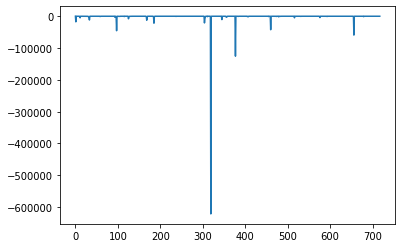

In [67]:
plt.plot(sarima_r2)

## SARIMAX Model

In [108]:
date_list = pd.date_range(clean_df.index[0], clean_df.index[clean_df.index < '2018-03-01 00:00:00' ][-1], freq='6H')

In [132]:
def sarimax_model_applier(df, order=(1,0,1), seasonal_order = (1,0,0,24), lag = 6*6, six_hour_steps_back = 5):
    
    test_values, results, exog_values = [], [], []
    
    
    for i in range(2+int(lag/36), len(date_list)-2):
        try:        
            train_frame =(df.index >= date_list[max([int(lag/6)+1, i - (six_hour_steps_back)])]) & (df.index < date_list[i-1]) & (df.index.minute == 0)
            test_frame = (df.index >= date_list[i-1]) & (df.index < date_list[i]) & (df.index.minute == 0)
            exog_frame = (df.index >= date_list[max([int(lag/6)+1, i - (six_hour_steps_back)])]) & (df.index < date_list[i+2]) & (df.index.minute == 0)
            
            if not any(train_frame):
                print('No valid train_frame.')
                continue

            df_train = df[wthr_columns].shift(lag)[train_frame].copy()
            df_train['target_losses_norm'] = list(df.target_losses_norm[train_frame])

            try:
                model = SARIMAX(df_train.target_losses_norm, exog=df_train[wthr_columns], order=order, seasonal_order=seasonal_order)
                result = model.fit(disp=-1)
            except Exception:
                print('Error on model.')
                continue

            if result == None:   
                print('No Result')
                continue

            test_value = clean_df.target_losses_norm[test_frame]
            if len(test_value) < lag/6:
                print('Test frame not long enough.')
                continue

            print(str(i) + ' of ' + str(len(date_list)))
            results.append(result)
            test_values.append(test_value)
            exog_values.append(df[wthr_columns][exog_frame])
        
        except Exception:
            print('Had to skip ' + str(i))
            continue
        
    return results, test_values, exog_values

In [123]:
sarimax_results, sarimax_test, sarimax_exog = sarimax_model_applier(clean_df.copy())

No valid train_frame.
No valid train_frame.
No valid train_frame.
No valid train_frame.
No valid train_frame.
No valid train_frame.


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


9 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


10 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


11 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


12 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


13 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


14 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


15 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


16 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


17 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


18 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


19 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


20 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


21 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


22 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


23 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


24 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


25 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


26 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


27 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


28 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


29 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


30 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


31 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


32 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


33 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


34 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


35 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


36 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


37 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


38 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


39 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


40 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


41 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


42 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


43 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


44 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


45 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


46 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


47 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


48 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


49 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


50 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


51 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


52 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


53 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


54 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


55 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


56 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


57 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


58 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


59 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


60 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


61 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


62 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


63 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


64 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


65 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


66 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


67 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


68 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


69 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


70 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


71 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


72 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


73 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


74 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


75 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


76 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


77 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


78 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


79 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


80 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


81 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


82 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


83 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


84 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


85 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


86 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


87 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


88 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


89 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


90 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


91 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


92 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


93 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


94 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


95 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


96 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


97 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


98 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


99 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


100 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


101 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


102 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


103 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


104 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


105 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


106 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


107 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


108 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


109 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


110 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


111 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


112 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


113 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


114 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


115 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


116 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


117 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


118 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


119 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


120 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


121 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


122 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


123 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


124 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


125 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


126 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


127 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


128 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


129 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


130 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


131 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


132 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


133 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


134 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


135 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


136 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


137 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


138 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


139 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


140 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


141 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


142 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


143 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


144 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


145 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


146 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


147 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


148 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


149 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


150 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


151 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


152 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


153 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


154 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


155 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


156 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


157 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


158 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


159 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


160 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


161 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


162 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


163 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


164 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


165 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


166 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


167 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


168 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


169 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


170 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


171 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


172 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


173 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


174 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


175 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


176 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


177 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


178 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


179 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


180 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


181 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


182 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


183 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


184 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


185 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


186 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


187 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


188 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


189 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


190 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


191 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


192 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


193 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


194 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


195 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


196 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


197 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


198 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


199 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


200 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


201 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


202 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


203 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


204 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


205 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


206 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


207 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


208 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


209 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


210 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


211 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


212 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


213 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


214 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


215 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


216 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


217 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


218 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


219 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


220 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


221 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


222 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


223 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


224 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


225 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


226 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


227 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


228 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


229 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


230 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


231 of 235
232 of 235


C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [124]:
sarimax_exog[5].shape

(42, 25)

In [131]:
sarimax_test[i]

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,date_by_hour,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,...,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation,time_delta
2018-01-04 06:00:00,0.247060,0.263655,0.016596,2018-01-04 07:00:00+01:00,0.0,11.100281,468.417009,99001.28,1.256278,0.004835,...,100.138918,108.290469,9.223262,4.631745,9.705565,13.782393,2018-01-04 00:00:00+00:00,111.474556,-12.149828,00:10:00
2018-01-04 07:00:00,0.230549,0.238665,0.008117,2018-01-04 08:00:00+01:00,0.0,10.331987,384.854717,99036.36,1.370567,0.004870,...,97.759261,105.760978,8.525738,4.203477,9.055212,12.839601,2018-01-04 00:00:00+00:00,122.502907,-3.785437,00:10:00
2018-01-04 08:00:00,0.148931,0.161360,0.012429,2018-01-04 09:00:00+01:00,0.0,9.482080,326.475828,99065.14,1.402138,0.004885,...,96.274863,103.298133,7.854416,3.765361,8.390822,11.975189,2018-01-04 00:00:00+00:00,134.118347,3.583294,00:10:00
2018-01-04 09:00:00,0.099368,0.112911,0.013543,2018-01-04 10:00:00+01:00,30.0,8.750000,352.785559,99087.31,1.084063,0.005020,...,93.462773,100.279087,7.233997,3.485096,7.697717,11.173013,2018-01-04 00:00:00+00:00,146.579437,9.579552,00:10:00
2018-01-04 10:00:00,0.105365,0.114721,0.009356,2018-01-04 11:00:00+01:00,130.0,8.245867,558.543906,99099.44,0.470575,0.005189,...,88.796248,95.535410,6.814351,3.678295,7.134702,10.425157,2018-01-04 00:00:00+00:00,159.943771,13.810913,00:10:00
2018-01-04 11:00:00,0.119634,0.127964,0.008329,2018-01-04 12:00:00+01:00,115.0,8.253672,761.445947,99102.44,0.181212,0.005257,...,83.561249,88.563767,7.190181,4.384567,7.421386,10.165260,2018-01-04 00:00:00+00:00,174.003082,15.933703,00:10:00


In [169]:
sarimax_rmse = []
for i in range(4,len(sarimax_test)):
    y_test = sarimax_test[i].target_losses_norm
    y_pred = sarimax_results[i].predict(1, len(sarimax_results[i].fittedvalues)+36, exog = sarimax_exog[i][:37])[-37:-31]
    _, rmse, _, _ = regr_eval(y_test, y_pred, return_scores=True, print_scores=False)
    sarimax_rmse.append(round(rmse,6))


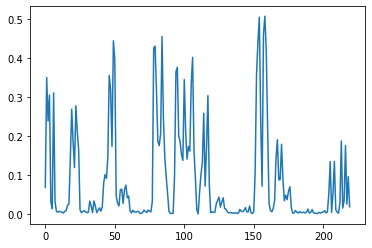

In [170]:
plt.plot(sarimax_rmse)

In [171]:
sarimax_test[40]

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,date_by_hour,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,...,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation,time_delta
2018-01-13 06:00:00,0.197784,0.202829,0.005045,2018-01-13 07:00:00+01:00,0.0,9.019836,444.633013,102992.88750,0.181724,0.003723,...,300.265530,330.570828,7.810972,4.883179,7.638089,5.580189,2018-01-13 00:00:00+00:00,110.050133,-11.845138,00:10:00
2018-01-13 07:00:00,0.216055,0.219624,0.003569,2018-01-13 08:00:00+01:00,0.0,9.113159,451.245278,102991.45000,0.180262,0.003730,...,301.227151,326.833035,7.904943,4.932556,7.729974,6.094091,2018-01-13 00:00:00+00:00,121.131813,-3.377200,00:10:00
2018-01-13 08:00:00,0.248126,0.252927,0.004800,2018-01-13 09:00:00+01:00,0.0,9.205551,459.726206,103014.55000,0.177769,0.003730,...,302.321082,326.280197,7.874240,4.921133,7.705217,6.863262,2018-01-13 00:00:00+00:00,132.793594,4.128631,00:10:00
2018-01-13 09:00:00,0.243050,0.247413,0.004362,2018-01-13 10:00:00+01:00,30.0,8.925000,483.109758,103043.57500,-0.013634,0.003725,...,304.541765,326.060809,7.835739,5.122482,7.678726,7.199362,2018-01-13 00:00:00+00:00,145.317047,10.289040,00:10:00
2018-01-13 10:00:00,0.240275,0.245334,0.005058,2018-01-13 11:00:00+01:00,50.0,8.602380,513.357183,103061.47500,-0.098419,0.003715,...,305.148875,322.552679,7.631460,5.125090,7.487847,7.153030,2018-01-13 00:00:00+00:00,158.783310,14.699553,00:10:00
2018-01-13 11:00:00,0.269538,0.275140,0.005603,2018-01-13 12:00:00+01:00,70.0,8.399908,565.988792,103062.64375,-0.166353,0.003695,...,305.219456,316.813933,7.489394,5.092087,7.355681,7.310542,2018-01-13 00:00:00+00:00,172.998749,16.997801,00:10:00


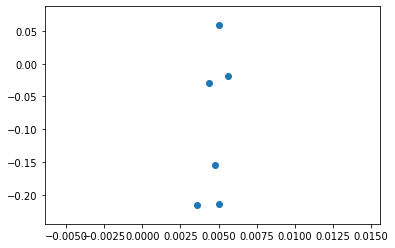

In [172]:
plt.scatter(sarimax_test[40].target_losses_norm, sarimax_results[40].predict(1, len(sarimax_results[40].fittedvalues)+36, exog = sarimax_exog[40][:37])[-6:])

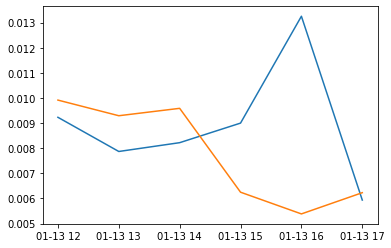

In [175]:
i = 41
plt.plot(sarimax_test[i].target_losses_norm) 
plt.plot(sarimax_results[i].predict(1, len(sarimax_results[i].fittedvalues)+36, exog = sarimax_exog[i][:37])[-37:-31])

## Regression Models